In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing import image

In [6]:
# 이미지 크기 및 배치 크기 설정
img_height = 224
img_width = 224
batch_size = 32

In [9]:
import os
for dirname, _, filenames in os.walk(r'C:\Users\hongj\Ai_test\image_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\hongj\Ai_test\image_data\cans\can1.jpg
C:\Users\hongj\Ai_test\image_data\cans\can10.jpg
C:\Users\hongj\Ai_test\image_data\cans\can11.jpg
C:\Users\hongj\Ai_test\image_data\cans\can12.jpg
C:\Users\hongj\Ai_test\image_data\cans\can13.jpg
C:\Users\hongj\Ai_test\image_data\cans\can14.jpg
C:\Users\hongj\Ai_test\image_data\cans\can15.jpg
C:\Users\hongj\Ai_test\image_data\cans\can16.jpg
C:\Users\hongj\Ai_test\image_data\cans\can17.jpg
C:\Users\hongj\Ai_test\image_data\cans\can18.jpg
C:\Users\hongj\Ai_test\image_data\cans\can19.jpg
C:\Users\hongj\Ai_test\image_data\cans\can2.jpg
C:\Users\hongj\Ai_test\image_data\cans\can20.jpg
C:\Users\hongj\Ai_test\image_data\cans\can21.jpg
C:\Users\hongj\Ai_test\image_data\cans\can22.jpg
C:\Users\hongj\Ai_test\image_data\cans\can23.jpg
C:\Users\hongj\Ai_test\image_data\cans\can24.jpg
C:\Users\hongj\Ai_test\image_data\cans\can3.jpg
C:\Users\hongj\Ai_test\image_data\cans\can4.jpg
C:\Users\hongj\Ai_test\image_data\cans\can5.jpg
C:\Users\hongj\Ai_test\im

In [11]:
import os
data_path = r'C:\Users\hongj\Ai_test\image_data'
class_name = ['cans', 'glass', 'other_ps', 'p_bowls', 'pets']
def get_list_files(dirname):
    files_list = os.listdir(dirname)
    return files_list

files_list_cans = get_list_files(os.path.join(data_path, class_name[0]))
files_list_glass = get_list_files(os.path.join(data_path, class_name[1]))
files_list_other_ps = get_list_files(os.path.join(data_path, class_name[2]))
files_list_p_bowls = get_list_files(os.path.join(data_path, class_name[3]))
files_list_pets = get_list_files(os.path.join(data_path, class_name[4]))

print(len(files_list_cans))
print(len(files_list_glass))
print(len(files_list_other_ps))
print(len(files_list_p_bowls))
print(len(files_list_pets))

24
501
81
107
183


(384, 512, 3)


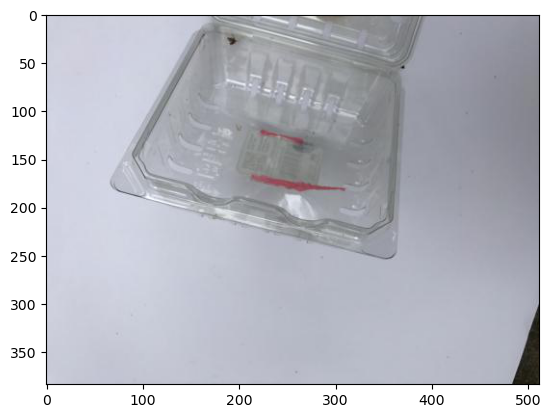

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

rand_img_no = np.random.randint(0, len(files_list_p_bowls))
img = os.path.join(data_path, 'p_bowls', files_list_p_bowls[rand_img_no])
print(plt.imread(img).shape)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [17]:
import shutil

# .ipynb_checkpoints 폴더 경로
checkpoints_folder = os.path.join(data_path, '.ipynb_checkpoints')

# .ipynb_checkpoints 폴더 삭제
if os.path.exists(checkpoints_folder):
    shutil.rmtree(checkpoints_folder)
    print(f"Deleted folder: {checkpoints_folder}")

In [19]:
# 데이터 증강 정의
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
], name='data_augmentation')

In [21]:
# ImageDataGenerator를 사용해 학습용 데이터셋 로드
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.3  # 30%를 검증용으로
)


In [23]:
train_dataset = train_datagen.flow_from_directory(
    data_path,
    target_size=(120, 120),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

Found 631 images belonging to 5 classes.


In [25]:
# 검증용 데이터셋 로드
validation_dataset = train_datagen.flow_from_directory(
    data_path,
    target_size=(120, 120),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 268 images belonging to 5 classes.


In [27]:
# 클래스 이름 가져오기
class_names = list(train_dataset.class_indices.keys())  # 클래스 이름 리스트로 변환


In [29]:
# tf.data.Dataset으로 변환
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_dataset,
    output_signature=(
        tf.TensorSpec(shape=(120, 120, 3), dtype=tf.float32),  # 배치 크기 없이
        tf.TensorSpec(shape=(len(class_names),), dtype=tf.float32)  # 배치 크기 없이
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: validation_dataset,
    output_signature=(
        tf.TensorSpec(shape=(120, 120, 3), dtype=tf.float32),  # 배치 크기 없이
        tf.TensorSpec(shape=(len(class_names),), dtype=tf.float32)  # 배치 크기 없이
    )
)

In [31]:
# 데이터셋을 배치 단위로 나누고 셔플
train_dataset = train_dataset.batch(16).shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

In [33]:
# 모델 정의
inputs = layers.Input(shape=(120, 120, 3))  # 입력 레이어 추가
x = data_augmentation(inputs)  # 데이터 증강 적용
x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)  # 첫 번째 Convolution 층
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)  # 두 번째 Convolution 층
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)  # 세 번째 Convolution 층
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)  # 2D 데이터를 1D로 변환
x = layers.Dense(128, activation='relu')(x)  # Fully Connected Layer
x = layers.Dropout(0.3)(x)  # 드롭아웃
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # 출력층

model = tf.keras.Model(inputs, outputs)  # 모델 생성

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # 다중 클래스 분류에 적합한 손실 함수
              metrics=['accuracy'])


In [35]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 120, 120, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 60, 60, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,867,557 (7.12 MB)

 Trainable params: 1,867,557 (7.12 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  
    restore_best_weights=True
)

In [ ]:
# 모델 학습
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=100, callbacks=[early_stopping])

Epoch 1/100
